# Imports

In [ ]:
pip install aiohttp

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score, recall_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
import asyncio
import json
import sqlite3
from sqlite3 import Error
from contextlib import contextmanager
from sqlalchemy import create_engine
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import numpy as np
import sys
import os
import json
import pandas as pd
from collections import Counter
import requests
from IPython.core.display import display, HTML
import lightgbm as lgb
import sklearn
import aiohttp
import asyncio
from sklearn import preprocessing
# from utils import (split_train_test, classification_metrics_binary, classification_metrics_binary_prob,
#                    binarize_prediction, plot_confusion_matrix, run_load_test, read_from_sqlite)
# from utils import BASELINE_MODEL, PORT, TABLE_FRAUD, TABLE_LOCATIONS, DATABASE_FILE

print("System version: {}".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("LightGBM version: {}".format(lgb.__version__))
print("Sklearn version: {}".format(sklearn.__version__))

%load_ext autoreload
%autoreload 2

System version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.18.1
Pandas version: 0.25.1
LightGBM version: 2.3.0
Sklearn version: 0.21.3


/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('creditcard.csv')

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
df.shape

(284807, 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
df.shape

(284807, 31)

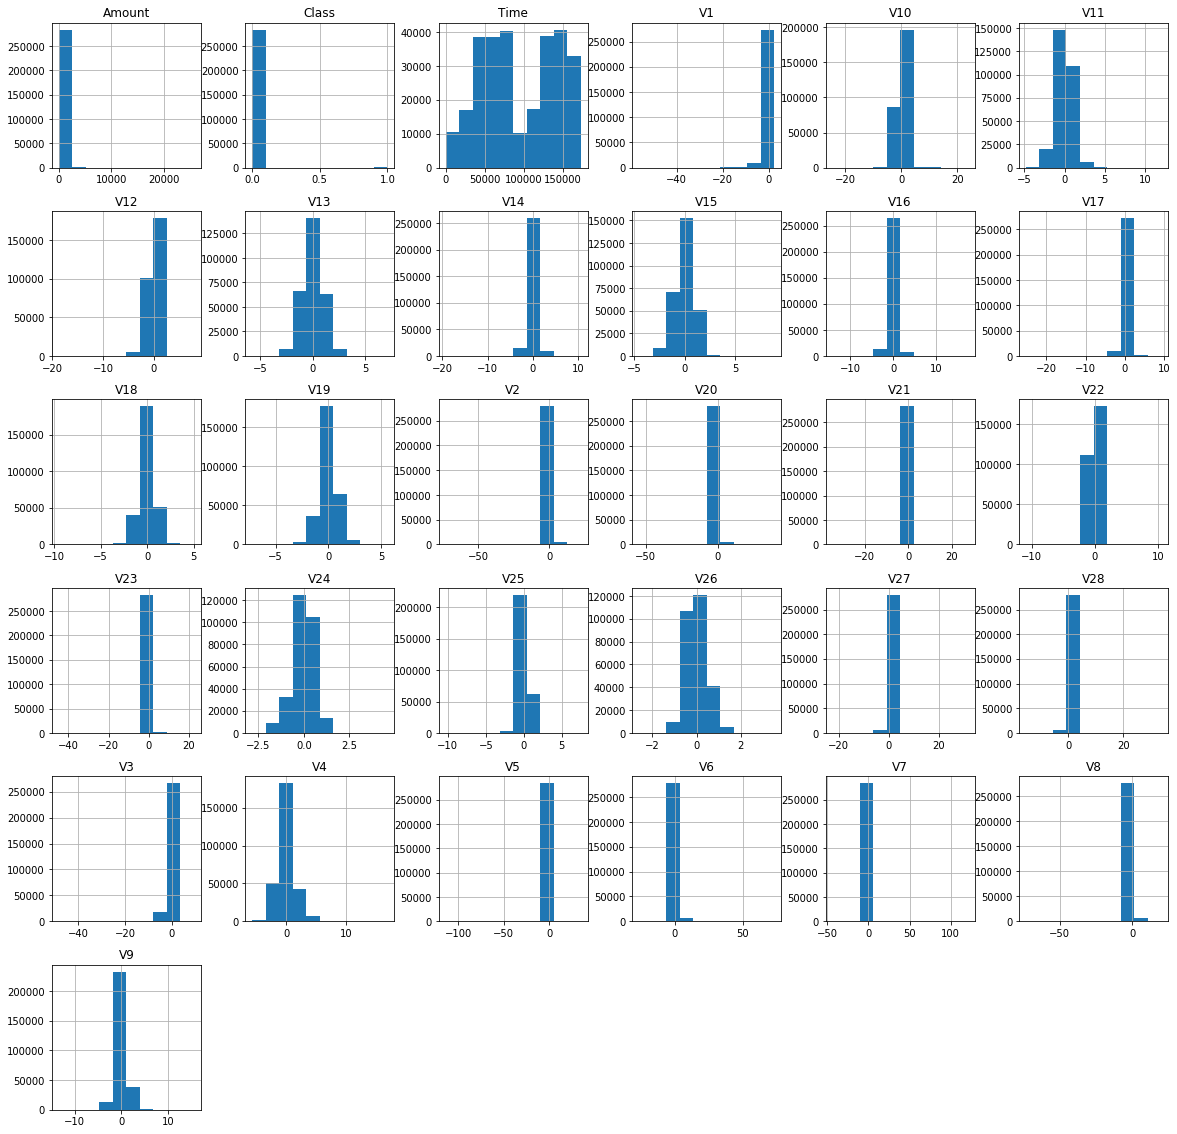

In [10]:
#Histogram
df.hist(figsize=(20,20))
plt.show()

In [11]:
fraud = df[df['Class']==1]
valid = df[df['Class']==0]

In [12]:
outlier_fraction = len(fraud)/float(len(valid))
print(outlier_fraction)

0.0017304750013189597


In [13]:
print(f'Fraud Cases: {len(fraud)}')
print(f'Valid Cases: {len(valid)}')

Fraud Cases: 492
Valid Cases: 284315


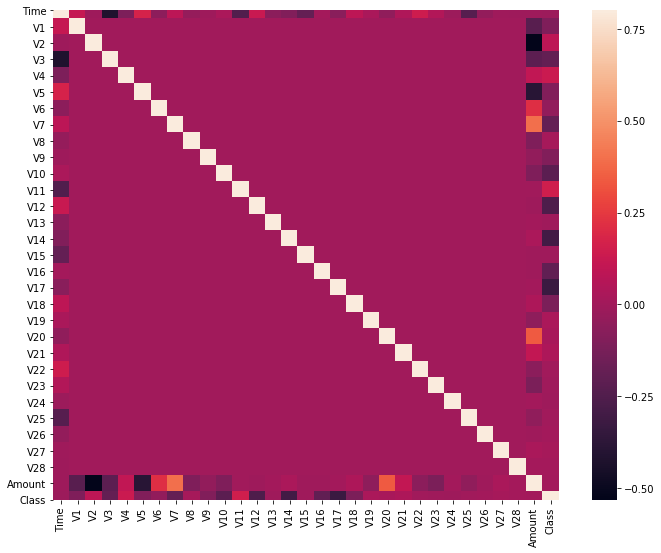

In [14]:
#correlation matrix
corrmat= df.corr()
fig = plt.figure(figsize=(12,9))

sns.heatmap(corrmat,vmax=.8, square = True)
plt.show()

In [15]:
corrmat.Class.sort_values(kind="quicksort")

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

In [16]:
# get all columns from df
cols = list(df.columns)

In [17]:
#filter class from columns
cols.remove('Class')

In [18]:
X = df[cols]
y = df['Class']

In [19]:
X.shape

(284807, 30)

In [20]:
y.shape

(284807,)

In [21]:
list(df.columns)

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [22]:
dffraud = df[['Time','Amount','Class']]

In [23]:
df[['Time','Amount','Class']].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


In [24]:
dffraud[dffraud['Class']==0].describe()

,Time,Amount,Class
count,284315.000000,284315.000000,284315.0
mean,94838.202258,88.291022,0.0
std,47484.015786,250.105092,0.0
min,0.000000,0.000000,0.0
25%,54230.000000,5.650000,0.0
50%,84711.000000,22.000000,0.0
75%,139333.000000,77.050000,0.0
max,172792.000000,25691.160000,0.0


In [25]:
dffraud[dffraud['Class']==1].describe()

,Time,Amount,Class
count,492.000000,492.000000,492.0
mean,80746.806911,122.211321,1.0
std,47835.365138,256.683288,0.0
min,406.000000,0.000000,1.0
25%,41241.500000,1.000000,1.0
50%,75568.500000,9.250000,1.0
75%,128483.000000,105.890000,1.0
max,170348.000000,2125.870000,1.0


In [26]:
dffraud[dffraud['Class']==1]

,Time,Amount,Class
541,406.0,0.00,1
623,472.0,529.00,1
4920,4462.0,239.93,1
6108,6986.0,59.00,1
6329,7519.0,1.00,1
...,...,...,...
279863,169142.0,390.00,1
280143,169347.0,0.76,1
280149,169351.0,77.89,1
281144,169966.0,245.00,1


In [27]:
dffraud[dffraud['Class']==0]

,Time,Amount,Class
0,0.0,149.62,0
1,0.0,2.69,0
2,1.0,378.66,0
3,1.0,123.50,0
4,2.0,69.99,0
...,...,...,...
284802,172786.0,0.77,0
284803,172787.0,24.79,0
284804,172788.0,67.88,0
284805,172788.0,10.00,0


In [28]:
# Portion that is not fraud
df['Class'].value_counts()[0]/len(df)

0.9982725143693799

In [29]:
# Portion that is fraud
df['Class'].value_counts()[1]/len(df)

0.001727485630620034

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

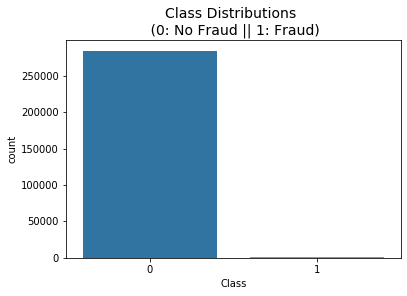

In [30]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Text(0.5, 1.0, 'Distribution of Transaction Time')

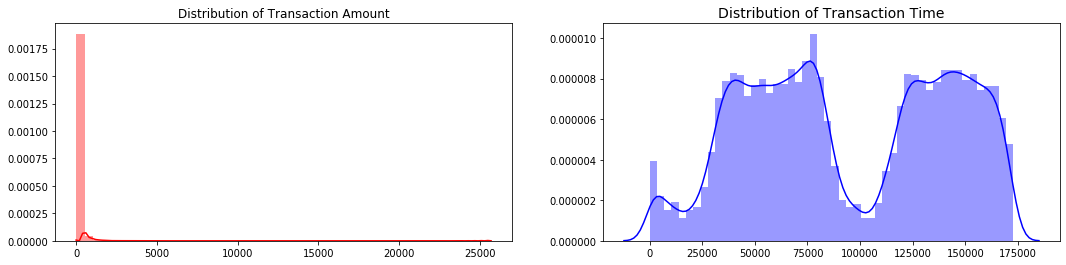

In [31]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.distplot(df['Amount'].values, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount')

sns.distplot(df['Time'].values, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.distplot(df['scaled_time'].values, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.distplot(df[dffraud['Class']==1]['scaled_time'].values, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize = 14)

# Scaling and Distributing

In [ ]:
#what does imbalanced classes do?

In [ ]:
# shouldnt we scale after we split?

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [33]:
std_scaler = StandardScaler()
rbst_scaler = RobustScaler()

In [34]:
df['scaled_amount'] = rbst_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [35]:
df['scaled_time'] = rbst_scaler.fit_transform(df['Time'].values.reshape(-1,1))

### Splitting The Data

In [39]:
X = df.drop('Class', axis =1)

In [40]:
y = df['Class']

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

In [42]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
sss = StratifiedKFold(n_splits= 5, random_state = None, shuffle = False)

In [44]:
for train_index, test_index in sss.split(X,y):
    print(f"Train: {train_index}, Test: {test_index}")
    original_Xtrain, original_Xtest= X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    

Train: [ 30473  30496  31002 ... 284804 284805 284806], Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806], Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806], Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806], Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868], Test: [212516 212644 213092 ... 284804 284805 284806]


In [45]:
# turn all into array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [46]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Random Under-Sampling

In [47]:
df.sample(frac=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
138033,-0.835229,0.687904,1.398559,-0.446036,0.998501,1.673941,0.354058,0.694589,-0.728787,-0.389804,...,-0.011105,0.102711,-1.349781,-0.524855,0.198798,0.364149,0.152708,0,0.097673,-0.026293
69368,1.201970,0.679912,-0.082867,2.299521,0.577990,-0.298661,0.617789,-0.238795,-1.095271,0.659201,...,-1.203240,-0.015641,-0.495103,0.510579,-0.251890,-0.037068,0.018570,0,0.268707,-0.367744
270904,1.786548,-1.447392,-0.160446,-0.370986,-1.399805,0.271095,-1.250653,0.241818,0.433825,0.650498,...,-0.149840,0.253509,0.686683,-0.504381,-0.793556,0.072489,0.001280,0,1.584573,0.935455
56264,1.102415,0.087240,0.342982,0.427102,-0.241936,-0.465971,0.121488,0.017862,-0.342655,0.036242,...,-1.282853,0.279077,0.193149,-0.076416,-0.027285,-0.046491,0.011199,0,0.250122,-0.438786
239140,1.984397,-0.432596,-1.246087,0.260772,0.082169,-0.040387,-0.248038,0.022980,0.712293,0.271454,...,-0.117466,0.052484,-1.099431,-0.131465,0.272659,-0.057758,-0.069448,0,0.320687,0.766973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196745,0.230057,1.243544,-1.251342,0.532777,1.639999,-0.781718,1.647589,-0.322354,-0.600441,-1.005810,...,0.471963,-0.059531,0.491888,-0.269334,-0.691311,0.155737,0.162968,0,0.264934,0.551945
119434,-4.273325,3.710445,-0.161510,-0.841839,-0.989906,-0.477873,0.250554,0.388949,3.236812,4.973389,...,-0.035013,0.018028,0.305093,0.687790,0.423729,2.109689,1.272964,0,-0.240481,-0.108671
85262,-4.352757,-4.552291,2.415313,2.240152,1.506433,-0.963031,-3.177216,1.175535,-0.302486,0.135571,...,-0.541537,-0.084470,0.154292,0.254620,-0.100428,0.402815,-0.613619,0,0.597918,-0.282029
228299,-1.667706,-2.670617,-0.051015,-1.643104,-0.134462,1.095888,-1.126426,0.931573,-2.346145,0.780340,...,0.589395,0.587991,-1.662755,-0.902810,0.003347,0.108523,-0.105824,0,3.170544,0.713801


In [48]:
fraud_df = df.loc[df["Class"]==1]
non_fraud_df = df.loc[df['Class']==0][:492]

In [49]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [50]:
new_df = normal_distributed_df.sample(frac= 1, random_state=42)

In [51]:
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
121,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,0.064800,...,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,0,-0.179976,-0.994079
248296,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,...,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1,-0.307413,0.812780
239,1.171439,0.474974,0.011761,1.264303,0.116234,-0.865986,0.554393,-0.276375,-0.471302,0.029104,...,0.278843,-0.097491,0.426278,0.744938,-0.274728,0.008472,0.015492,0,-0.027947,-0.993104
239501,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,...,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1,3.007895,0.768888
143336,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,-8.537758,...,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,1,3.226717,0.006967


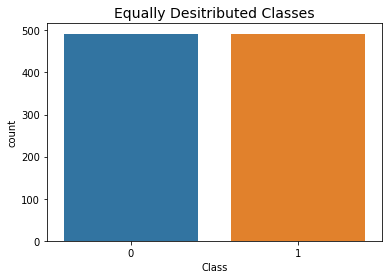

In [52]:
sns.countplot('Class', data=new_df)
plt.title("Equally Desitributed Classes", fontsize = 14)
plt.show()

In [53]:
corr = new_df.corr()

In [54]:
corr.Class.sort_values(kind="quicksort")

V14             -0.739062
V12             -0.701195
V10             -0.631532
V3              -0.613963
V16             -0.579323
V9              -0.564955
V17             -0.554530
V7              -0.484249
V6              -0.457721
V18             -0.435873
V1              -0.426422
V5              -0.378402
V15             -0.155419
V24             -0.098485
V25             -0.072055
V13             -0.018859
V23             -0.003291
V22              0.051141
V26              0.054539
V8               0.063857
V27              0.074154
V28              0.107971
scaled_amount    0.108269
V21              0.128754
V20              0.151902
V19              0.268535
V2               0.478113
V11              0.675408
V4               0.685672
scaled_time      0.766175
Class            1.000000
Name: Class, dtype: float64

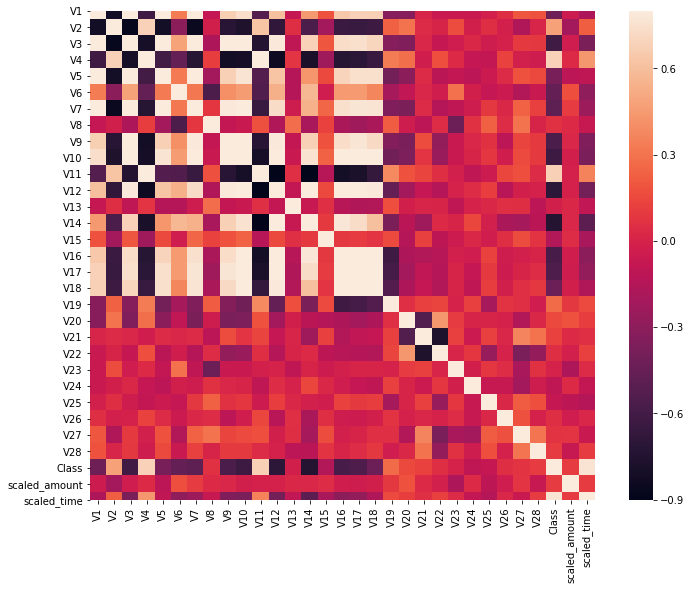

In [55]:
#correlation matrix

fig = plt.figure(figsize=(12,9))

sns.heatmap(corr,vmax=.8, square = True)
plt.show()

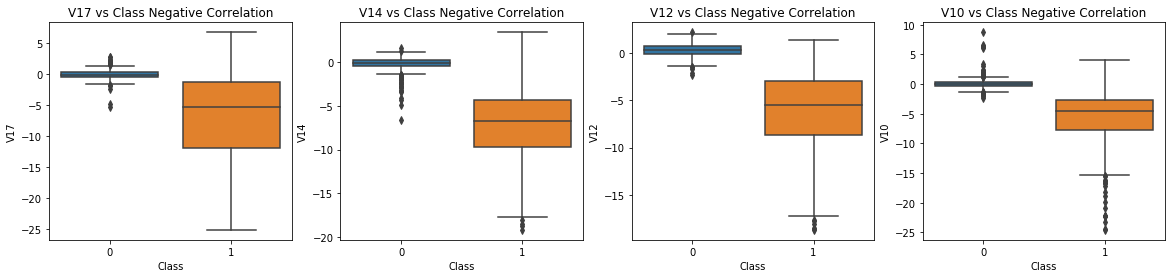

In [57]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df,  ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df,  ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

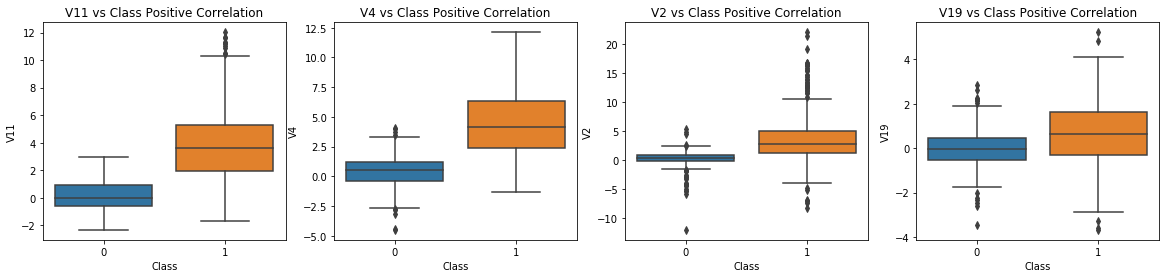

In [59]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df,  ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df,  ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df,  ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df,  ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()


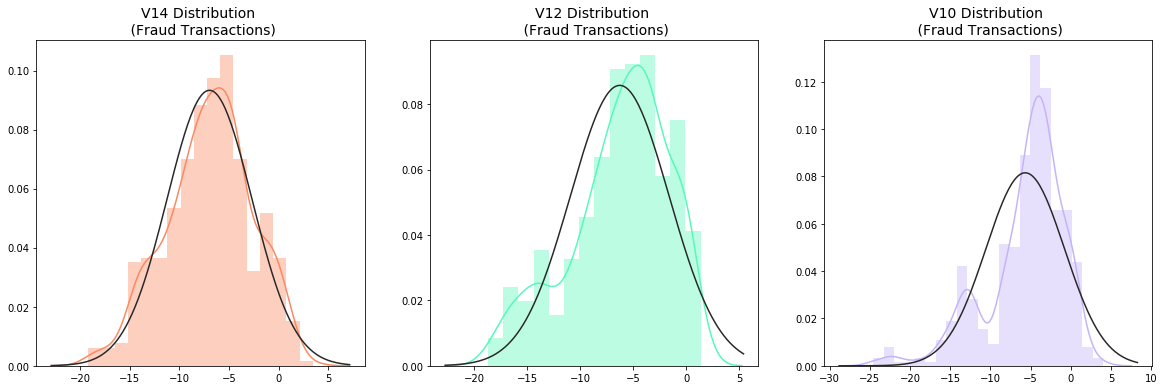

In [60]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### Dealing with Outliers for Neg Correlated Variables

In [61]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.683714633344298, -18.4311310279993, -18.047596570821604, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-18.2711681738888, -

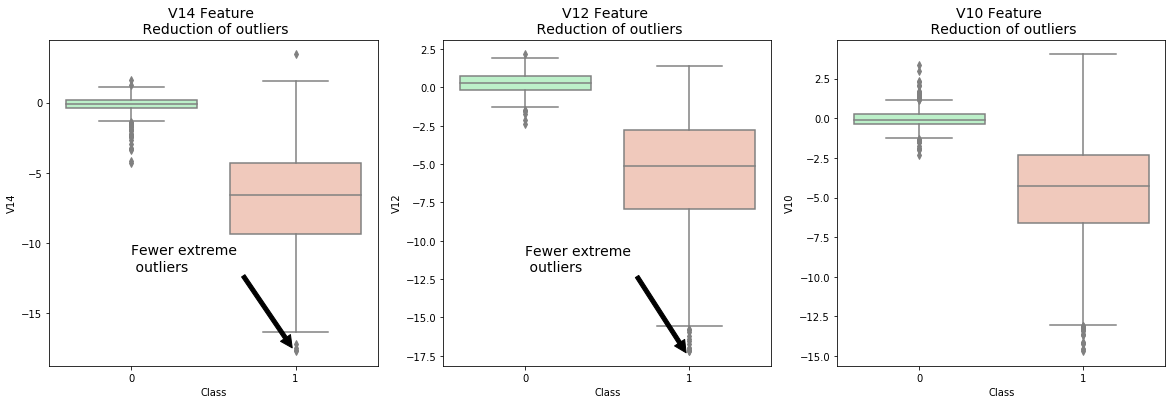

In [62]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

### t-SNE

In [63]:
import time

In [64]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [ ]:
c=new_df.corr().abs()

In [65]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))




T-SNE took 5.1 s
PCA took 0.0041 s
Truncated SVD took 0.0032 s


In [66]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

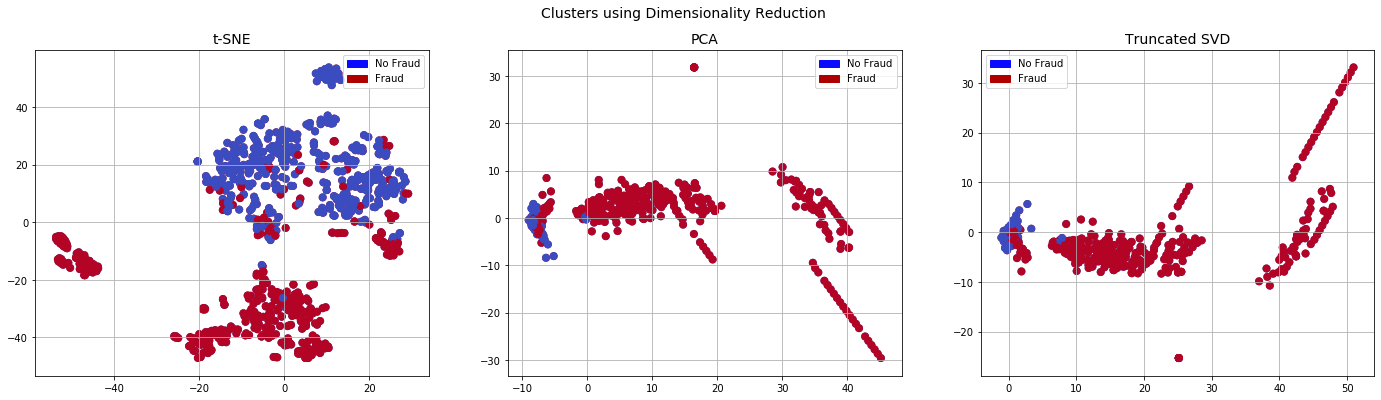

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Start Modeling

In [121]:
new_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
121,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,0.064800,...,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,0,-0.179976,-0.994079
248296,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,...,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1,-0.307413,0.812780
239,1.171439,0.474974,0.011761,1.264303,0.116234,-0.865986,0.554393,-0.276375,-0.471302,0.029104,...,0.278843,-0.097491,0.426278,0.744938,-0.274728,0.008472,0.015492,0,-0.027947,-0.993104
239501,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,...,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1,3.007895,0.768888
143336,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,-8.537758,...,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,1,3.226717,0.006967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41395,-4.446847,-0.014793,-5.126307,6.945130,5.269255,-4.297177,-2.591242,0.342671,-3.880663,-3.976525,...,-0.049586,-0.226017,-0.401236,0.856124,0.661272,0.492560,0.971834,1,-0.293440,-0.517276
142557,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,-0.713474,...,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,1,4.643750,0.001140
368,1.320626,-1.174338,0.713431,-2.177941,-1.511234,0.059314,-1.308064,0.298796,0.788814,-0.200099,...,-0.365280,0.064822,-0.322003,0.152701,-0.003131,0.075103,0.010941,0,-0.271082,-0.991823
239499,-2.150855,2.187917,-3.430516,0.119476,-0.173210,0.290700,-2.808988,-2.679351,-0.556685,-4.485483,...,0.561496,-0.075034,-0.437619,0.353841,-0.521339,0.144465,0.026588,1,0.391253,0.768877


In [ ]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [120]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [122]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [124]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [125]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 95.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


In [74]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [75]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  98.94%
Knears Neighbors Cross Validation Score 94.96%
Support Vector Classifier Cross Validation Score 99.47%
DecisionTree Classifier Cross Validation Score 99.87%


In [ ]:
conda install -c conda-forge imbalanced-learn

In [76]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss

In [77]:
from imblearn.pipeline import make_pipeline, Pipeline

In [78]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [79]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/johnrick/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

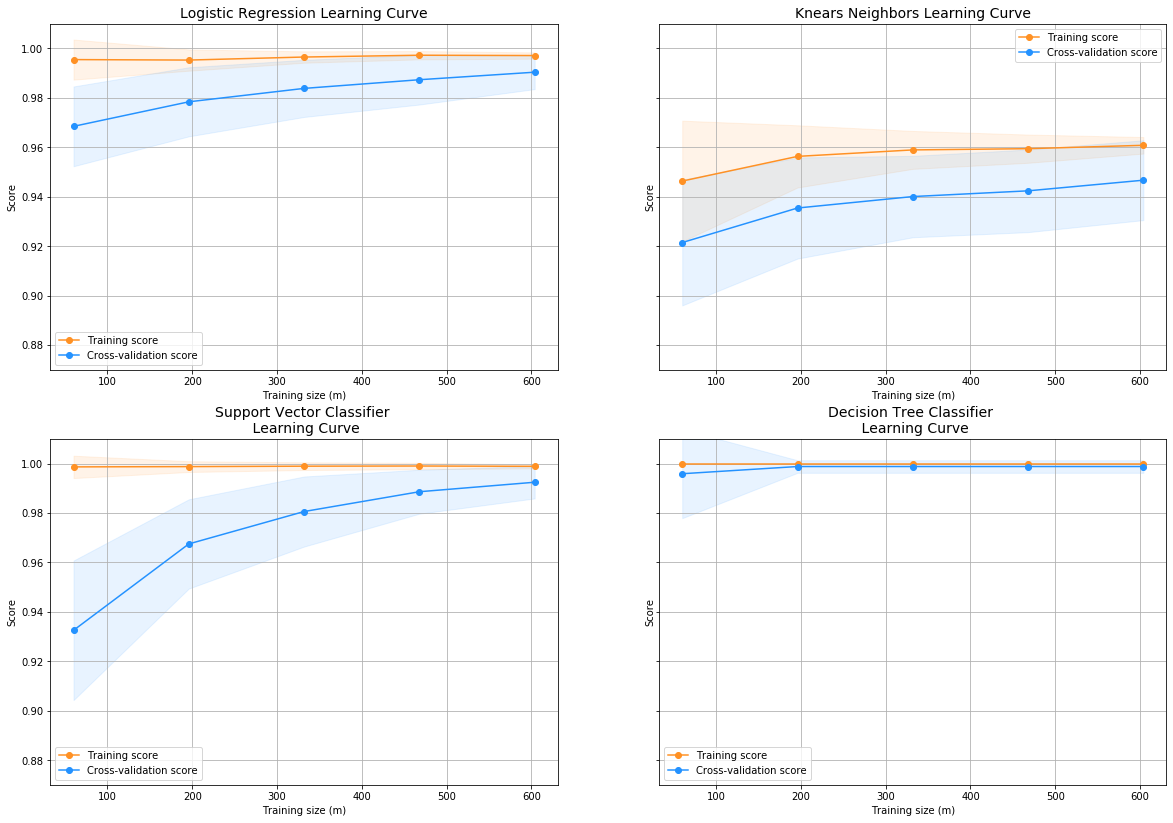

In [80]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [81]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [82]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))


Logistic Regression:  0.9998244579260757
KNears Neighbors:  0.9487698011459387
Support Vector Classifier:  0.9997893495112907
Decision Tree Classifier:  0.9986413043478262


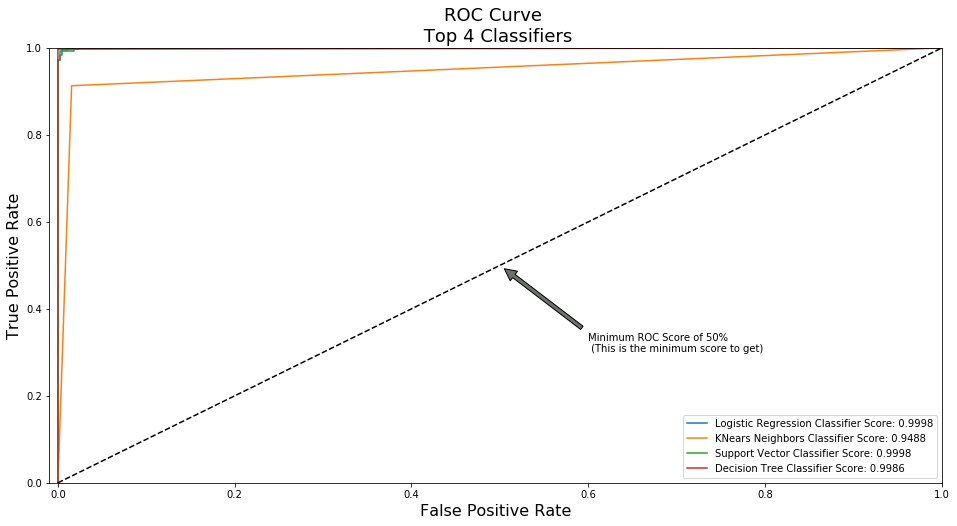

In [83]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## My Models

### Logistic Regression

In [126]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [144]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [145]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [147]:
logisticRegr = LogisticRegression()

In [148]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
pred = logisticRegr.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

In [150]:
print('Logistic Regression:')
print(classification_report(y_test, pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.98      0.96      0.97        82

    accuracy                           0.97       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.97      0.97      0.97       189



### Other Models: KNear, SVC, DT

In [155]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = logisticRegr.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

In [152]:
y_pred_knear = knears_neighbors.predict(X_test)

In [153]:
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)

In [154]:
print('KNearest:')
print(classification_report(y_test, y_pred_knear))

KNearest:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       107
           1       0.97      0.91      0.94        82

    accuracy                           0.95       189
   macro avg       0.96      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189



In [151]:
#Undersampling
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

In [ ]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

### End of My Models

## Logistic Regression

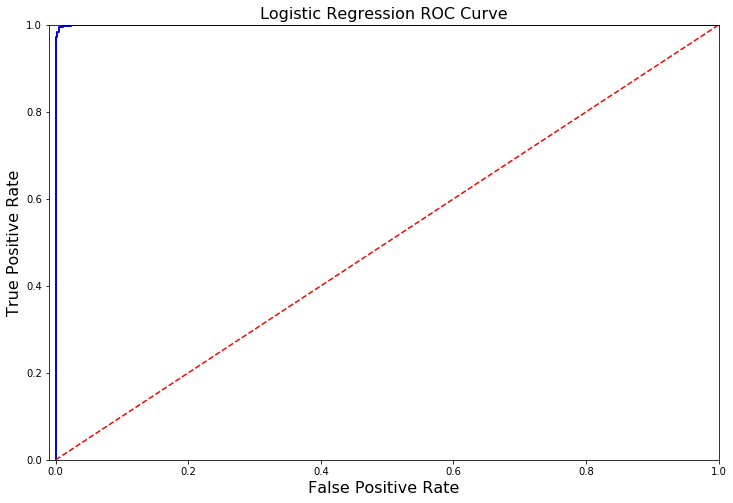

In [89]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()


In [84]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)


In [85]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)


---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.96
Precision Score: 0.61
F1 Score: 0.75
Accuracy Score: 0.69
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.54
Precision Score: 0.00
Recall Score: 0.94
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [86]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [87]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))


Average precision-recall score: 0.01


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.01')

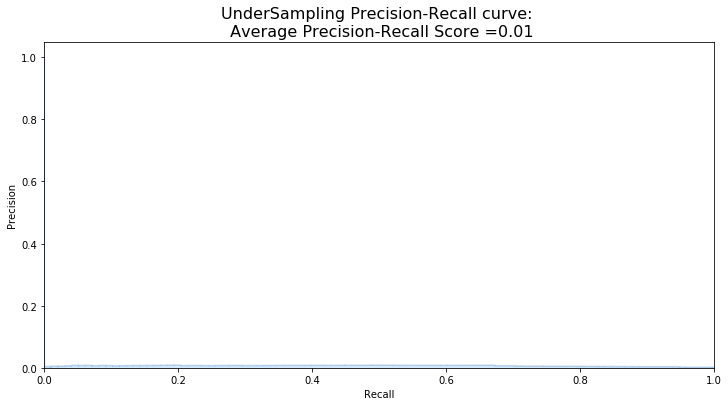

In [88]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)


In [90]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9429709347021132
precision: 0.06113223901423202
recall: 0.9136319376825707
f1: 0.11285091242048803
---------------------------------------------------------------------------------------------------------------------------------------


In [91]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))


              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.85      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [94]:
y_score = best_est.decision_function(original_Xtest)


In [95]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.76


In [93]:
y_score

NameError: name 'y_score' is not defined

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.76')

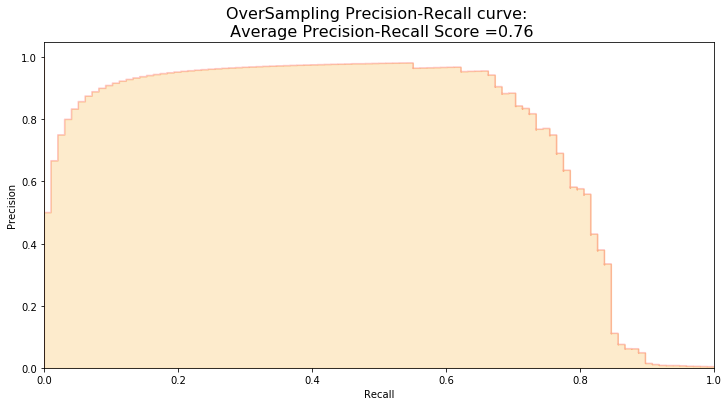

In [96]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)


In [97]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)


In [98]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))


Fitting oversample data took :38.07547211647034 sec


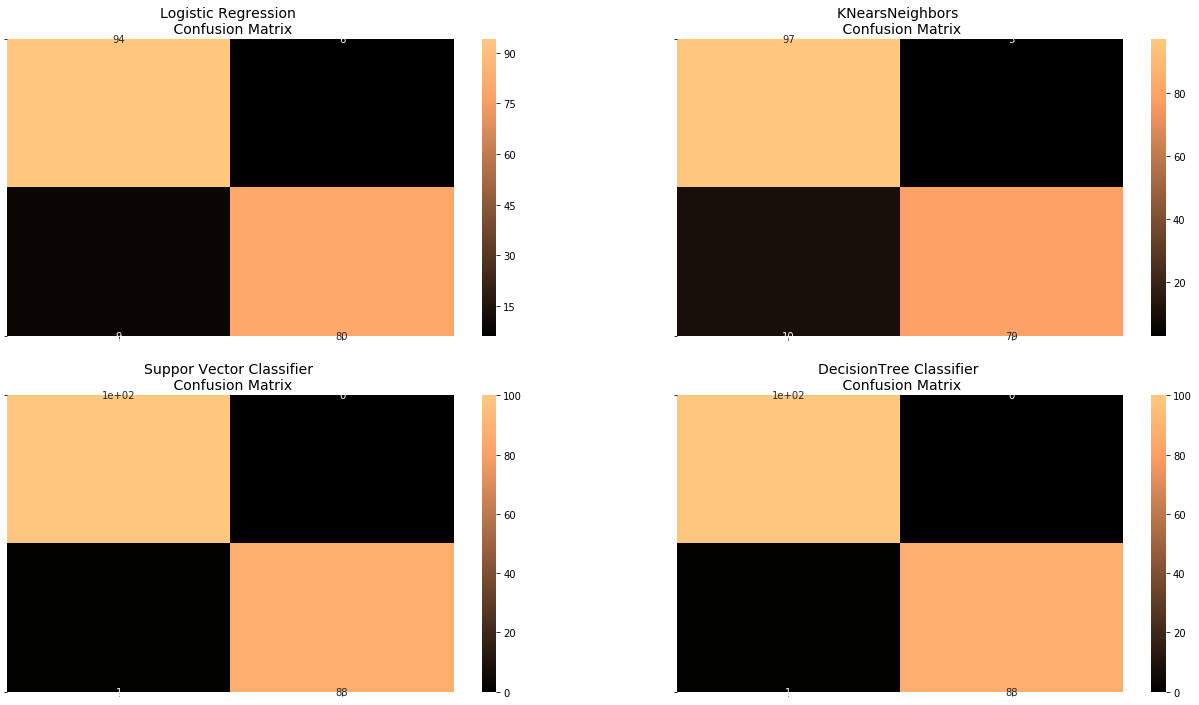

In [99]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()


In [100]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       100
           1       0.93      0.90      0.91        89

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       100
           1       0.96      0.89      0.92        89

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99        89

    accuracy                           0.99       189
   macro avg       1.00      0.99      0.99       189
weighted

In [101]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df


,Technique,Score
0,Random UnderSampling,0.920635
1,Oversampling (SMOTE),0.988115


## Neural Networks

In [104]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])


Using TensorFlow backend.


In [105]:
undersample_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [106]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [107]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 604 samples, validate on 151 samples
Epoch 1/20
 - 0s - loss: 0.4386 - accuracy: 0.8079 - val_loss: 0.3038 - val_accuracy: 0.9272
Epoch 2/20
 - 0s - loss: 0.2526 - accuracy: 0.9387 - val_loss: 0.2062 - val_accuracy: 0.9338
Epoch 3/20
 - 0s - loss: 0.1694 - accuracy: 0.9553 - val_loss: 0.1612 - val_accuracy: 0.9470
Epoch 4/20
 - 0s - loss: 0.1270 - accuracy: 0.9603 - val_loss: 0.1374 - val_accuracy: 0.9536
Epoch 5/20
 - 0s - loss: 0.1027 - accuracy: 0.9685 - val_loss: 0.1244 - val_accuracy: 0.9536
Epoch 6/20
 - 0s - loss: 0.0871 - accuracy: 0.9702 - val_loss: 0.1170 - val_accuracy: 0.9536
Epoch 7/20
 - 0s - loss: 0.0924 - accuracy: 0.9719 - val_loss: 0.1059 - val_accuracy: 0.9669
Epoch 8/20
 - 0s - loss: 0.0687 - accuracy: 0.9719 - val_loss: 0.1134 - val_accuracy: 0.9603
Epoch 9/20
 - 0s - loss: 0.0612 - accuracy: 0.9752 - val_loss: 0.1071 - val_accuracy: 0.9603
Epoch 10/20
 - 0s - loss: 0.0538 - accuracy: 0.9785 - val_loss: 0.1045 - val_accuracy: 0.9603
Epoch 11/20
 - 0s - los

In [108]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [109]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [110]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[20739 36124]
 [    0    98]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


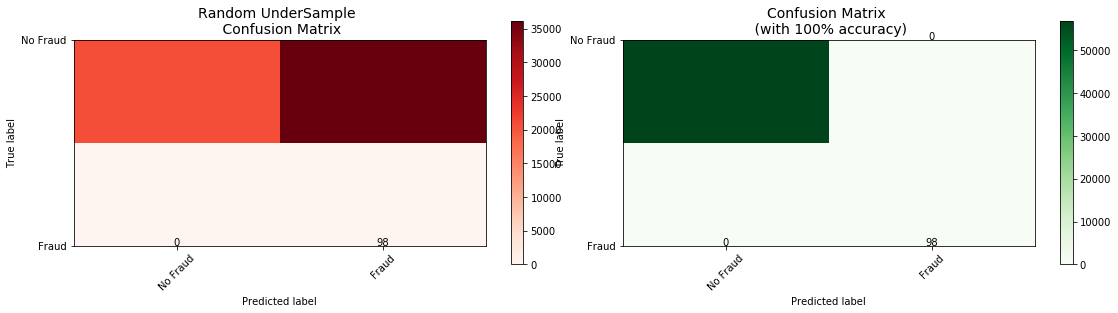

In [111]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)


In [113]:
36124/(20739+36124)

0.6352812901183547

In [114]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])


In [115]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [116]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)


Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 2s - loss: 0.0545 - accuracy: 0.9817 - val_loss: 0.0214 - val_accuracy: 0.9969
Epoch 2/20
 - 1s - loss: 0.0122 - accuracy: 0.9976 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/20
 - 1s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 4/20
 - 1s - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0047 - val_accuracy: 0.9995
Epoch 5/20
 - 1s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9999
Epoch 6/20
 - 1s - loss: 0.0029 - accuracy: 0.9995 - val_loss: 9.4037e-04 - val_accuracy: 0.9999
Epoch 7/20
 - 1s - loss: 0.0028 - accuracy: 0.9995 - val_loss: 7.4254e-04 - val_accuracy: 1.0000
Epoch 8/20
 - 1s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 8.1898e-04 - val_accuracy: 1.0000
Epoch 9/20
 - 1s - loss: 0.0018 - accuracy: 0.9997 - val_loss: 4.4358e-04 - val_accuracy: 1.0000
Epoch 10/20
 - 1s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 8.6640e-04 - val_accuracy: 0.999

In [117]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)


In [118]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)


Confusion matrix, without normalization
[[56855     8]
 [   28    70]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


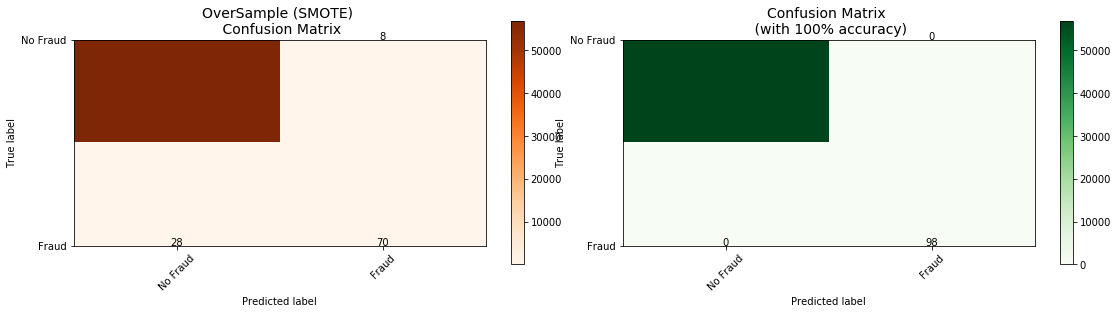

In [119]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df[cols]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X Train: {len(X_train)} \nX Test:{len(X_test)}\nY Train:{len(y_train)}\nY Test: {len(y_test)}")

In [ ]:
state= 1

In [ ]:
#we can also change n_neighbors to see how different it would look

In [ ]:
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X_train),
                                       contamination = outlier_fraction,
                                       random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
    n_neighbors= 20,
    contamination = outlier_fraction)
}

In [ ]:
# fit model
n_outliers = len(fraud)

for i,(clf_name, clf) in enumerate(classifiers.items()):
    print(i,(clf_name, clf))
    #fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X_train)
        scores_pred = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #reshape the prediction: 0 for valid, 1 for fraud
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1
    
    n_errors = (y_pred != y_train).sum()
    
    print(f"{clf_name}: {n_errors}")
    print(accuracy_score(y_train,y_pred))
    print(classification_report(y_train,y_pred))
    
    

## XGB

In [ ]:
import xgboost as xgb

In [ ]:
X = df[cols]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"X Train: {len(X_train)}, X Test:{len(X_test)}, Y Train:{len(y_train)}, Y Test: {len(y_test)}")

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
print(accuracy_score(y_train,training_preds))
print(classification_report(y_train,training_preds))

In [ ]:
print(accuracy_score(y_test,val_preds))
print(classification_report(y_test,val_preds))

# Cross Validation

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#testing models
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
clf = IsolationForest(max_samples=len(X_train),
                contamination = outlier_fraction,
                random_state=10)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_train)

In [ ]:
val_preds= clf.predict(X_test)

In [ ]:
training_accuracy=accuracy_score(y_train, y_pred)

In [ ]:
val_accuracy = accuracy_score(y_test, val_preds)

In [ ]:
training_accuracy

In [ ]:
val_accuracy

In [ ]:
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

In [ ]:
print(classification_report(y_train,y_pred))

In [ ]:
#Local Outlier Factor
y_pred = clf0.fit_predict(X_train)
scores_pred = clf0.negative_outlier_factor_




In [ ]:
len(y_pred)

In [ ]:
len(y_train)

In [ ]:
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1

In [ ]:
n_errors = (y_pred != y_train).sum()

In [ ]:
n_errors

In [ ]:
print(f"Local Outlier Factor: {n_errors}")
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
df['Class'].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

In [ ]:
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [ ]:
parameters = {'num_leaves': 2**8,
              'learning_rate': 0.1,
              'is_unbalance': True,
              'min_split_gain': 0.1,
              'min_child_weight': 1,
              'reg_lambda': 1,
              'subsample': 1,
              'objective':'binary',
              #'device': 'gpu', # comment this line if you are not using GPU
              'task': 'train'
              }
num_rounds = 300

In [ ]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

In [ ]:
y_prob = clf.predict(X_test)

In [ ]:
y_pred = binarize_prediction(y_prob, threshold=0.5)

In [ ]:
def classification_metrics_binary(y_true, y_pred):
    """Returns a report with different metrics for a binary classification problem.
    - Accuracy: Number of correct predictions made as a ratio of all predictions. Useful when there are equal number
    of observations in each class and all predictions and prediction errors are equally important.
    - Confusion matrix: C_ij where observations are known to be in group i but predicted to be in group j. In binary
    classification true negatives is C_00, false negatives is C_10, true positives is C_11 and false positives is C_01.
    - Precision: Number of true positives divided by the number of true and false positives. It is the ability of the
    classifier not to label as positive a sample that is negative.
    - Recall: Number of true positives divided by the number of true positives and false negatives. It is the ability
    of the classifier to find all the positive samples.
    High Precision and low Recall will return few positive results but most of them will be correct. 
    High Recall and low Precision will return many positive results but most of them will be incorrect.
    - F1 Score: 2*((precision*recall)/(precision+recall)). It measures the balance between precision and recall.
    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels (binary).
    Returns:
        report (dict): Dictionary with metrics.
    Examples:
        >>> from collections import OrderedDict
        >>> y_true = [0,1,0,0,1]
        >>> y_pred = [0,1,0,1,1]
        >>> result = classification_metrics_binary(y_true, y_pred)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('Accuracy', 0.8), ('Confusion Matrix', array([[2, 1],
               [0, 2]])), ('F1', 0.8), ('Precision', 0.6666666666666666), ('Recall', 1.0)])
    """
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    m_conf = confusion_matrix(y_true, y_pred)
    report = {'Accuracy': m_acc, 'Precision': m_precision,
              'Recall': m_recall, 'F1': m_f1, 'Confusion Matrix': m_conf}
    return report


def classification_metrics_binary_prob(y_true, y_prob):
    """Returns a report with different metrics for a binary classification problem.
    - AUC: The Area Under the Curve represents the ability to discriminate between positive and negative classes. An
    area of 1 represent perfect scoring and an area of 0.5 means random guessing.
    - Log loss: Also called logistic regression loss or cross-entropy loss. It quantifies the performance by
    penalizing false classifications. Minimizing the Log Loss is equivalent to minimizing the squared error but using
    probabilistic predictions. Log loss penalize heavily classifiers that are confident about incorrect classifications.
    Args:
        y_true (list or np.array): True labels.
        y_prob (list or np.array): Predicted labels (probability).
    Returns:
        report (dict): Dictionary with metrics.
    Examples:
        >>> from collections import OrderedDict
        >>> y_true = [0,1,0,0,1]
        >>> y_prob = [0.2,0.7,0.4,0.3,0.2]
        >>> result = classification_metrics_binary_prob(y_true, y_prob)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('AUC', 0.5833333333333333), ('Log loss', 0.6113513950783531)])
        >>> y_prob = [0.2,0.7,0.4,0.3,0.3]
        >>> result = classification_metrics_binary_prob(y_true, y_prob)
        >>> OrderedDict(sorted(result.items()))
        OrderedDict([('AUC', 0.75), ('Log loss', 0.5302583734567203)])
    """
    m_auc = roc_auc_score(y_true, y_prob)
    m_logloss = log_loss(y_true, y_prob)
    report = {'AUC': m_auc, 'Log loss': m_logloss}
    return report


def binarize_prediction(y, threshold=0.5):
    """Binarize prediction based on a threshold
    Args:
        y (np.array): Array with predictions.
        threshold (float): Theshold value for binarization.
    """
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Args:
        cm (np.array): The confusion matrix array.
        classes (list): List wit the classes names.
        normalize (bool): Flag to normalize data.
        title (str): Title of the plot.
        cmap (matplotlib.cm): Matplotlib colormap https://matplotlib.org/api/cm_api.html
    Examples:
        >>> import numpy as np
        >>> a = np.array([[10, 3, 0],[1, 2, 3],[1, 5, 9]])
        >>> classes = ['cl1', 'cl2', 'cl3']
        >>> plot_confusion_matrix(a, classes, normalize=False)
        >>> plot_confusion_matrix(a, classes, normalize=True)
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0:
        cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)

    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect locking of semaphore
    def http_get(url, payload, verbose):
        nonlocal semaphore
        with (yield from semaphore):
            headers = {'content-type': 'application/json'}
            response = yield from s.request('post', url, data=json.dumps(payload), headers=headers)
            if verbose:
                print("Response status:", response.status)
            body = yield from response.json()
            if verbose:
                print(body)
            yield from response.wait_for_close()
        return body
    return http_get


def run_load_test(url, payloads, _session, concurrent, verbose):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)

    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url, payload, verbose) for payload in payloads]

    dfs_route = []
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data = yield from future
        try:
            dfs_route.append(data)
        except Exception as err:
            print("Error {0}".format(err))
    return dfs_route

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
metrics  =  classification_metrics_binary(y_test, y_pred)
metrics2 = classification_metrics_binary_prob(y_test, y_prob)
metrics.update(metrics2)
cm = metrics['Confusion Matrix']
metrics.pop('Confusion Matrix', None)

In [ ]:
print(json.dumps(metrics, indent=3, sort_keys=True))
plot_confusion_matrix(cm, ['no fraud (negative class)', 'fraud (positive class)'])

In [ ]:
def binarize_prediction(y, threshold=0.5):
    """Binarize prediction based on a threshold
    Args:
        y (np.array): Array with predictions.
        threshold (float): Theshold value for binarization.
    """
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

# Create Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
aa